## Noise2Void Denoising with Synthetic Microsim Dataset

This notebook demonstrates Noise2Void (N2V) denoising on synthetic microscopy data generated using Microsim. The dataset is generated using cosem, a wrapper around the Janelia OpenOrganelle dataset. This is a rich dataset of FIB-SEM images of cells, together with annotations of various organelles.

### Part 1: Generating Synthetic Data with Microsim

We'll use the Janelia COSEM dataset to create realistic cellular structures. The COSEM dataset contains segmented organelles from electron microscopy data.

In [1]:
import numpy as np
import warnings
from typing import Annotated, Any, Literal
from annotated_types import Ge
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imread
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics.utils import autocorrelation
from microssim import micro_structural_similarity
from microsim import schema as ms
from microsim.util import ortho_plot
from microsim.cosem import CosemDataset
from microsim.schema.optical_config import lib
from skimage.transform import downscale_local_mean

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we must create the microsim ground truth which returns the position and quantity of fluorophores in the sample.

In [2]:
sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"),
                fluorophore="mTagBFP2",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EGFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
            ),
        ]
    ),
    channels=[lib.DAPI, lib.FITC, lib.DSRED],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=1),
    output_path="h2-cf.tif",
    settings=ms.Settings(max_psf_radius_aus=2),
)

[13:45:41:865123] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=54787;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=940716;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[13:45:52:938180] INFO     Ground truth generated in 11.07 seconds                                ]8;id=935090;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=376490;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

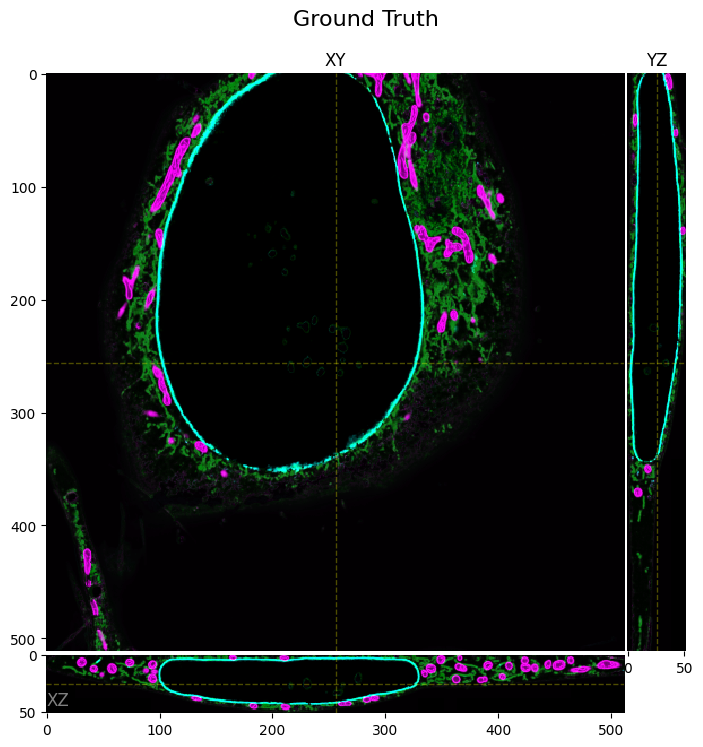

In [3]:
ground_truth = sim.ground_truth() # ground truth for microsim
ortho_plot(ground_truth, title="Ground Truth", cmap=["cyan", "green", "magenta"])

We use the microsim ground truth to create a biologically realistic ground truth for N2V. We do this by using the _optical_image_ function, which convolves the scaled fluorophore distributions with the optical point spread function (PSF) of the microscope to form the (noise free) optical image.

[13:45:53:294648] INFO     Creating optical_image ...                                             ]8;id=346517;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=876822;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[13:45:53:296965] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=520559;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=351883;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[13:45:53:298815] INFO     Ground truth generated in 0.00 seconds                                 ]8;id=462424;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=813797;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[13:45:53:470432] INFO     Rendering Confocal channel DAPI ---------------                        ]8;id=365866;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=318078;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[13:45:53:473160] INFO       Fluor: mTagBFP2                                                      ]8;id=176772;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=343706;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:45:53:678594] INFO         Need PSF (52,513) @ 461.1 nm (weight=19.84)                       ]8;id=841384;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=993419;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:45:53:683038] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.46            ]8;id=571346;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=714198;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:45:55:583859] INFO       Fluor: EGFP                                                          ]8;id=218322;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=838373;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:45:55:630819] INFO         Need PSF (52,513) @ 479.9 nm (weight=0.14)                        ]8;id=312575;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=373080;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:45:55:633953] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.48            ]8;id=349882;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=143248;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:45:57:545897] INFO       Fluor: mScarlet                                                      ]8;id=537168;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=362418;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:45:57:611875] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=782067;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=927177;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[13:45:57:614740] INFO       Fluor: mTagBFP2                                                      ]8;id=978245;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=975207;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:45:57:661682] INFO         Need PSF (52,513) @ 518.0 nm (weight=0.01)                        ]8;id=835714;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=43326;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:45:57:664816] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=126948;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=312846;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:45:59:576942] INFO       Fluor: EGFP                                                          ]8;id=556466;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=212930;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:45:59:623654] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=388594;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=738706;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:45:59:626886] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=112716;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=646941;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:01:552916] INFO       Fluor: mScarlet                                                      ]8;id=425512;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=136410;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:01:600589] INFO         Need PSF (52,513) @ 546.5 nm (weight=0.04)                        ]8;id=842366;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=901623;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:01:603886] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.55            ]8;id=150012;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=489378;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:03:552036] INFO     Rendering Confocal channel DSRED ---------------                       ]8;id=941870;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=801949;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[13:46:03:554666] INFO       Fluor: mTagBFP2                                                      ]8;id=227982;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=478655;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:03:621232] INFO       Fluor: EGFP                                                          ]8;id=146536;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=902301;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:03:687668] INFO         Need PSF (52,513) @ 610.9 nm (weight=0.05)                        ]8;id=989839;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=827062;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:03:690651] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.61            ]8;id=773755;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=983497;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:05:589023] INFO       Fluor: mScarlet                                                      ]8;id=216182;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=359371;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:05:657531] INFO         Need PSF (52,513) @ 615.8 nm (weight=194.40)                      ]8;id=733105;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=892145;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:05:660524] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.62            ]8;id=833409;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=108625;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

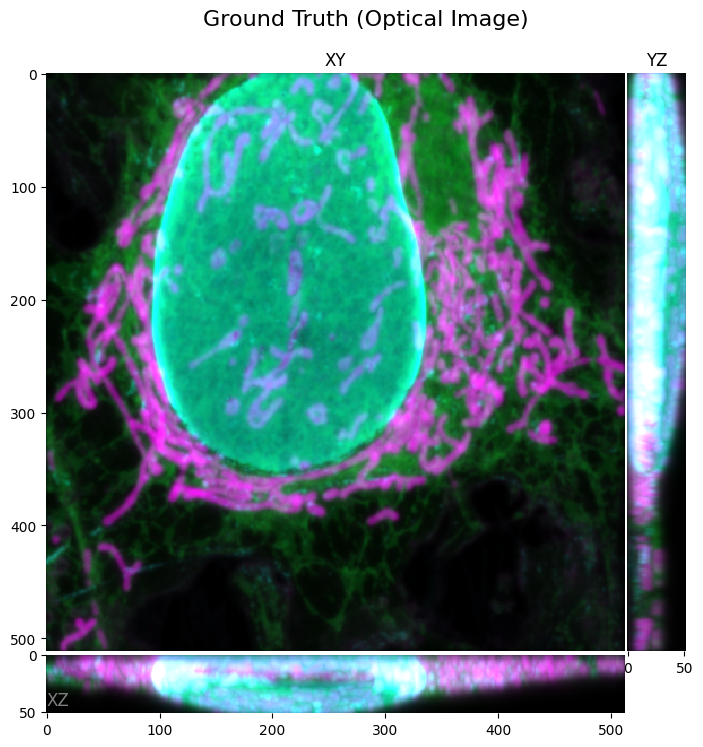

In [4]:
optical_image_gt = sim.optical_image() # this is the ground truth we use for N2V
ortho_plot(optical_image_gt, title="Ground Truth (Optical Image)", cmap=["cyan", "green", "magenta"], mip=True)

Next we generate the _noisy_image_ for N2V. This is done by simulating the final stage of image acquisition with the _digital_image_ function. This function takes the noise-free _optical_image_ and applies realistic detector effects. Here we simulate a CameraCCD detector with a high _read_noise_ of 15 electrons and an electronic gain of 3.0 to amplify the weak signal. Combined with a very short exposure_ms of 5 milliseconds, this process introduces significant shot noise and electronic noise, creating a low signal-to-noise ratio image that is ideal for training a denoising model.

[13:46:08:626471] INFO     Creating optical_image ...                                             ]8;id=393233;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=292334;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[13:46:08:628636] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=354015;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=136851;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[13:46:16:158280] INFO     Ground truth generated in 7.53 seconds                                 ]8;id=723912;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=461025;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[13:46:16:283858] INFO     Rendering Confocal channel DAPI ---------------                        ]8;id=107459;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=906381;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[13:46:16:286062] INFO       Fluor: mTagBFP2                                                      ]8;id=360024;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=634578;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:16:425855] INFO         Need PSF (52,513) @ 461.1 nm (weight=19.84)                       ]8;id=154553;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=696845;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:16:428989] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.46            ]8;id=826478;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=590072;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:18:318552] INFO       Fluor: EGFP                                                          ]8;id=585450;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=624692;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:18:372497] INFO         Need PSF (52,513) @ 479.9 nm (weight=0.14)                        ]8;id=36382;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=132312;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:18:374906] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.48            ]8;id=479866;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=522208;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:20:296757] INFO       Fluor: mScarlet                                                      ]8;id=275729;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=284271;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:20:362756] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=135456;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=133610;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[13:46:20:365501] INFO       Fluor: mTagBFP2                                                      ]8;id=28832;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=881926;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:20:416478] INFO         Need PSF (52,513) @ 518.0 nm (weight=0.01)                        ]8;id=431155;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=713147;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:20:419500] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=520941;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=334672;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:22:313241] INFO       Fluor: EGFP                                                          ]8;id=792912;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=545638;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:22:367664] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=157115;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=446390;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:22:370026] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=787110;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=435832;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:24:251668] INFO       Fluor: mScarlet                                                      ]8;id=942744;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=664610;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:24:297737] INFO         Need PSF (52,513) @ 546.5 nm (weight=0.04)                        ]8;id=493442;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=416992;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:24:300733] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.55            ]8;id=5603;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=134222;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:26:360712] INFO     Rendering Confocal channel DSRED ---------------                       ]8;id=795706;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=89166;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[13:46:26:363520] INFO       Fluor: mTagBFP2                                                      ]8;id=607174;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=699674;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:26:430156] INFO       Fluor: EGFP                                                          ]8;id=190774;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=240899;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:26:499977] INFO         Need PSF (52,513) @ 610.9 nm (weight=0.05)                        ]8;id=227097;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=880836;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:26:502456] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.61            ]8;id=576595;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=259760;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:28:398390] INFO       Fluor: mScarlet                                                      ]8;id=407016;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=963048;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[13:46:28:468610] INFO         Need PSF (52,513) @ 615.8 nm (weight=194.40)                      ]8;id=85475;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=995066;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[13:46:28:471669] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.62            ]8;id=991594;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=8598;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[13:46:30:708770] INFO     Creating digital_image ...                                             ]8;id=431925;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=357904;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[13:46:30:711144] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=903909;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=566449;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[13:46:31:196801] INFO     Simulating CameraCCD detector ...                                      ]8;id=215874;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=273759;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[13:46:31:975993] INFO     Digital image generated in 1.27 seconds                                ]8;id=958919;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=419241;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

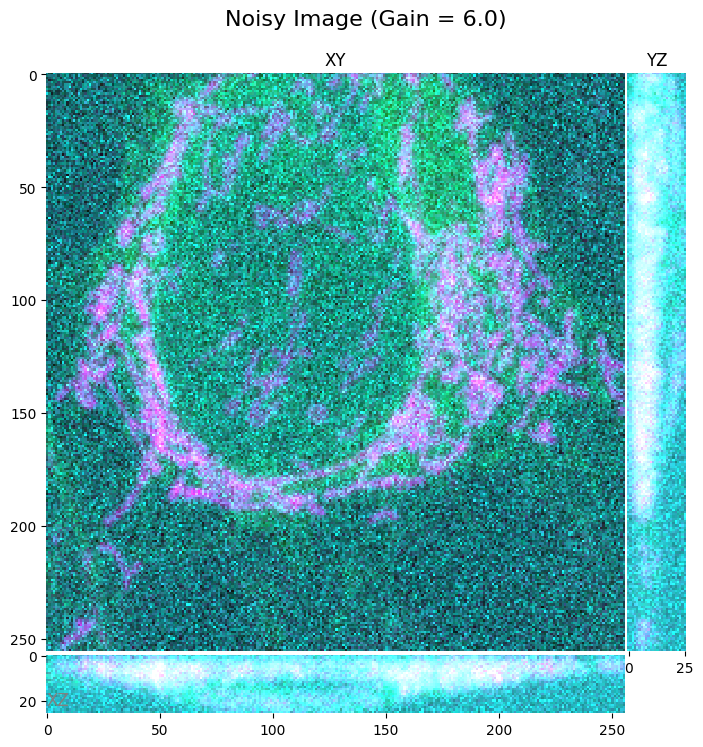

In [5]:
sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"),
                fluorophore="mTagBFP2",
                concentration=0.7 
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EGFP",
                concentration=0.7  
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
                concentration=0.7 
            ),
        ]
    ),
    channels=[lib.DAPI, lib.FITC, lib.DSRED],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=30, gain=6.0),
    settings=ms.Settings(max_psf_radius_aus=2),
)

ground_truth_optical = sim.optical_image()
noisy_image = sim.digital_image(ground_truth_optical, exposure_ms=5)

ortho_plot(noisy_image, title="Noisy Image (Gain = 6.0)", cmap=["cyan", "green", "magenta"], mip=True)

### Visualizing the generated data
The microsim simulation has a 3D volume and we take a 2D slice for 2D N2V training and prediction for this example notebook.

In [6]:
# Select the best Z-slice based on the ground truth signal
signal_per_z = optical_image_gt.sum(axis=(0, 2, 3)).data
z_slice_index = np.argmax(signal_per_z)
print(f"Using Z-slice {z_slice_index} for training.")
channel_index = 1
gt_slice = optical_image_gt.data[channel_index, z_slice_index]
noisy_slice = noisy_image.data[channel_index, z_slice_index]

print(f"Shape of training slice (noisy_slice): {noisy_slice.shape}")

Using Z-slice 10 for training.
Shape of training slice (noisy_slice): (256, 256)


## Part 2: Noise2Void Denoising with CAREamics
Now that we have generated our microsim data, we'll train a Noise2Void model to denoise our images.


### Configure and train the Noise2Void model

In [7]:
# Create a configuration for an N2V model
config = create_n2v_configuration(
    experiment_name="microsim_n2v",
    data_type="array",
    axes="YX",
    patch_size=[64, 64],
    batch_size=16,
    num_epochs=50,
)

# Initialize CAREamist with the configuration
careamist = CAREamist(source=config)

# Train the model on the noisy_slice
careamist.train(
    train_source=noisy_slice,
    val_percentage=0.1,
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [157.02615356], std: [75.79238694]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, train_loss_step=0.329, val_loss=0.35, train_loss_epoch=0.329] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, train_loss_step=0.329, val_loss=0.35, train_loss_epoch=0.329]


### Predict using the trained model

In [8]:
signal_per_z = optical_image_gt.sum(axis=(0, 2, 3)).data
z_slice_high_res_index = np.argmax(signal_per_z)
print(f"Using Z-slice {z_slice_high_res_index} from high-resolution ground truth.")
channel_index = 1

# Get the 2D high-resolution clean slice from the optical_image
gt_slice_high_res = optical_image_gt[channel_index, z_slice_high_res_index].data

# Get the corresponding 2D low-resolution noisy slice from the digital_image
downscale_factor = sim.output_space.downscale
# Divide the z-index by the downscale factor to find the matching slice
z_slice_low_res_index = z_slice_high_res_index // downscale_factor
noisy_slice = noisy_image.data[channel_index, z_slice_low_res_index]

# Downsample the ground truth
gt_slice_low_res = downscale_local_mean(
    gt_slice_high_res,
    factors=(downscale_factor, downscale_factor)
).astype(gt_slice_high_res.dtype)

Using Z-slice 10 from high-resolution ground truth.
Ground truth slice shape (after downsampling): (256, 256)
Noisy slice shape: (256, 256)


In [9]:
predictions = careamist.predict(
    source=noisy_slice,
    data_type="array",
    axes="YX",
    tile_size=(128, 128),
    tile_overlap=(64, 64),
    batch_size=1,
)
denoised_images = np.squeeze(np.array(predictions))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 209.77it/s]


### Evaluate denoising performance and visualize the results

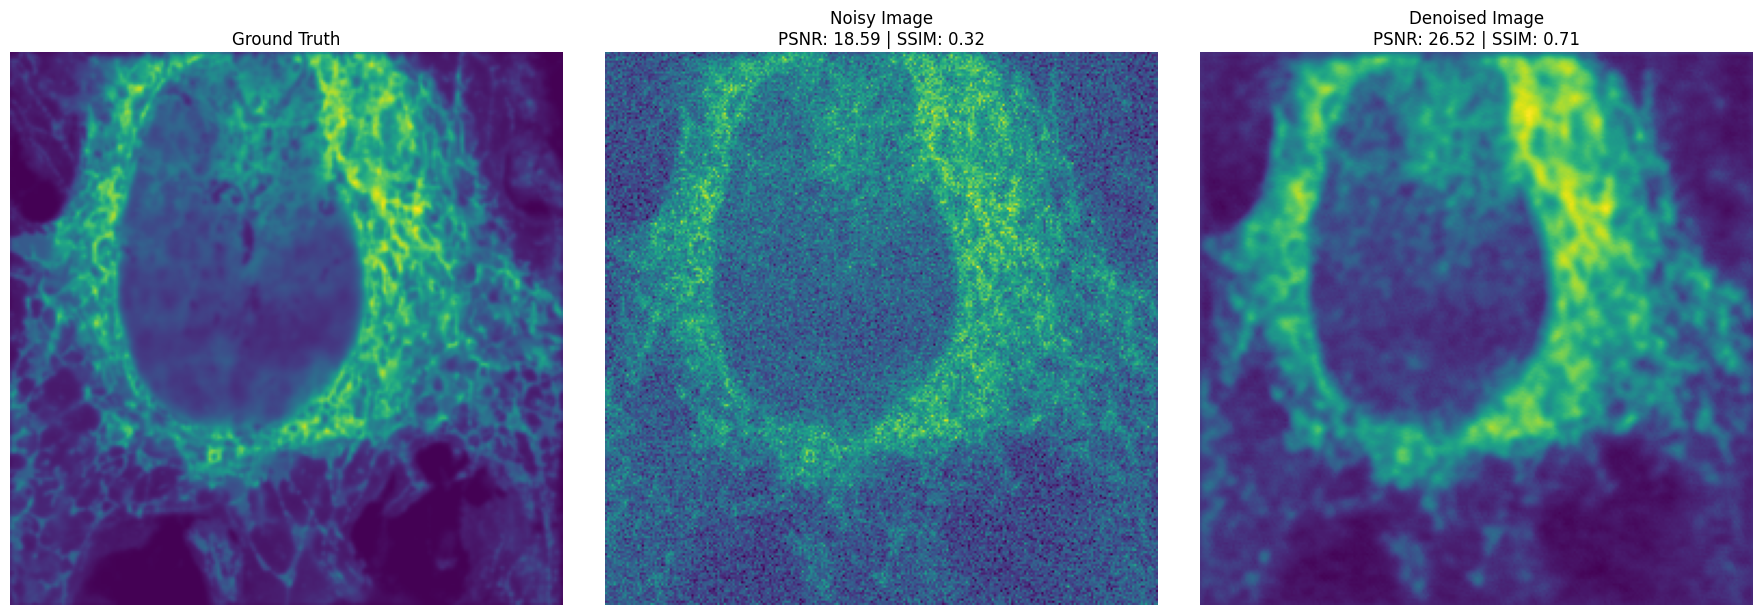

In [10]:
# Normalize images 
def normalize(img):
    min_val, max_val = img.min(), img.max()
    return (img - min_val) / (max_val - min_val) if max_val > min_val else img - min_val

gt_normalized = normalize(gt_slice_low_res)
noisy_normalized = normalize(noisy_slice)
denoised_normalized = normalize(denoised_images)

# Compute metrics
psnr_noisy = scale_invariant_psnr(gt_normalized, noisy_normalized)
ssim_noisy = micro_structural_similarity(gt_normalized, noisy_normalized)
psnr_denoised = scale_invariant_psnr(gt_normalized, denoised_normalized)
ssim_denoised = micro_structural_similarity(gt_normalized, denoised_normalized)

# Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(gt_normalized, cmap='viridis')
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(noisy_normalized, cmap='viridis')
ax[1].set_title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} | SSIM: {ssim_noisy:.2f}')
ax[1].axis('off')

ax[2].imshow(denoised_normalized, cmap='viridis')
ax[2].set_title(f'Denoised Image\nPSNR: {psnr_denoised:.2f} | SSIM: {ssim_denoised:.2f}')
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Plot training metrics

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


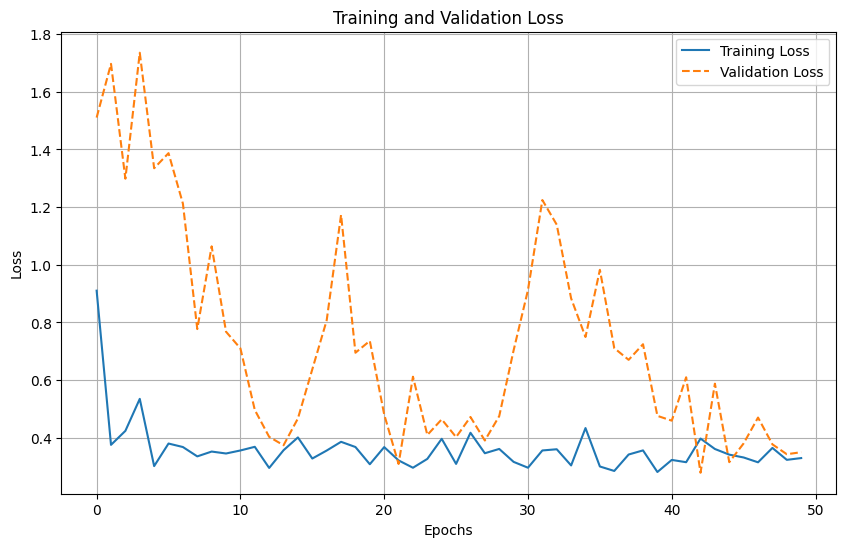

In [11]:
losses = careamist.get_losses()
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = list(range(len(train_losses)))
val_epochs = list(range(len(val_losses)))

# Plot the losses
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

### Create a visualization for a comparison of before/after

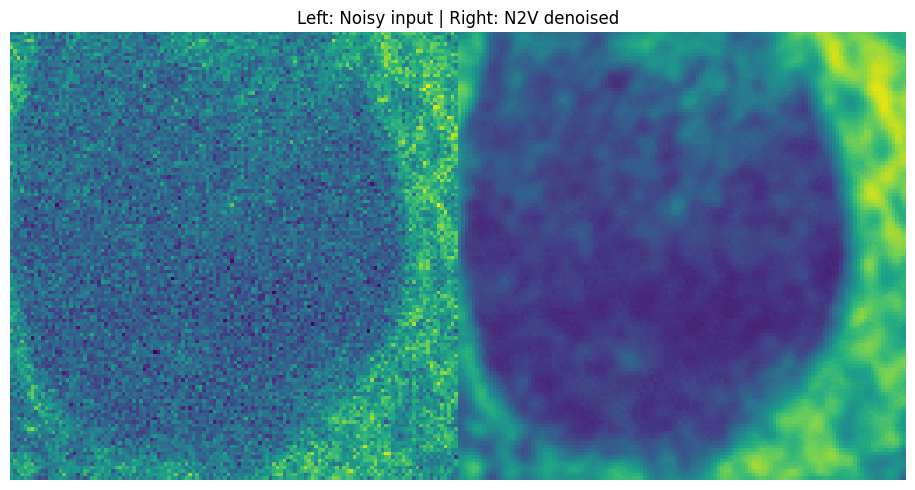

In [12]:
# Create a side-by-side comparison image
x_start, y_start = 50, 50  
size = 128
norm_noisy = (noisy_slice - noisy_slice.min()) / (noisy_slice.max() - noisy_slice.min())
norm_denoised = (denoised_images - denoised_images.min()) / (denoised_images.max() - denoised_images.min())

# Crop regions and concatenate
noisy_crop = norm_noisy[y_start:y_start+size, x_start:x_start+size]
denoised_crop = norm_denoised[y_start:y_start+size, x_start:x_start+size]
comparison = np.concatenate([noisy_crop, denoised_crop], axis=1)

plt.figure(figsize=(10, 5))
plt.imshow(comparison, cmap="viridis")
plt.title("Left: Noisy input | Right: N2V denoised")
plt.axis('off')
plt.tight_layout()
plt.savefig("Microsim_N2V_comparison.jpg", dpi=300, bbox_inches='tight')
plt.show()

### And you're done! Now we can export the model to BMZ format

In [13]:
# Define description for the model
general_description = """
This model is trained using the Noise2Void (N2V) algorithm to denoise synthetic microscopy images 
generated with Microsim. The images simulate tubular structures resembling microtubules labeled 
with EGFP and imaged using a widefield fluorescence microscope.

N2V enables training without clean data by masking pixels and predicting their values from 
surrounding context.
"""
# Export the model
careamist.export_to_bmz(
    path_to_archive="microsim_n2v_model.zip",
    friendly_model_name="Microsim_N2V",
    input_array=noisy_slice.astype(np.float32),  # Use 2D slice
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description="Synthetic widefield fluorescence microscopy data of EGFP-labeled mitochondrial membranes simulated with Microsim"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.58it/s]


[13:47:02:673138] WARNING  Your CAREamics version seems to be a locally modified version              ]8;id=733182;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py\version.py]8;;\:]8;id=568023;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py#29\29]8;;\
                           (0.0.12.dev13+gce27d0d). The recorded version for loading models will be                
                           0.0.12, which may not exist. If you want to ensure exporting the model                  
                           with an existing version, please install the closest CAREamics version                  
                           from PyPI or conda-forge.                                                               

[13:47:02:677085] WARNING  Your CAREamics version seems to be a locally modified version              ]8;id=599781;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py\version.py]8;;\:]8;id=541091;file:///home/diya.srivastava/Desktop/careamics/src/careamics/utils/version.py#29\29]8;;\
                           (0.0.12.dev13+gce27d0d). The recorded version for loading models will be                
                           0.0.12, which may not exist. If you want to ensure exporting the model                  
                           with an existing version, please install the closest CAREamics version                  
                           from PyPI or conda-forge.                                                               

computing SHA256 of inputs.npy (result: bc48f0e76da10a0faf08361bac457552c3442cf60827b704c98807439412aec8): 100%|██████████| 262272/262272 [00:00<00:00, 242568577.44it/s]
computing SHA256 of outputs.npy (result: 0b3e859289adabf199ba67ae14e4a3c5b3d449401da4bc7aaec277884b4b43cb): 100%|██████████| 262272/262272 [00:00<00:00, 321463617.38it/s]
computing SHA256 of environment.yml (result: bbf164cd3dd96acb2abdceede0c319cf29488ba6d51d34fae21d44c31f65d76a): 100%|██████████| 131/131 [00:00<00:00, 232720.81it/s] 
computing SHA256 of weights.pth (result: aadefa9dad7fe63977c0cd80b4f51700422ae3735892c3730c4360e5bcb7ad65): 100%|██████████| 2066750/2066750 [00:00<00:00, 904767539.09it/s] 
computing SHA256 of careamics.yaml (result: 24f97290459c57973566805f43a9b410830eb22b6d966e8852e488d4a3179b62): 100%|██████████| 1408/1408 [00:00<00:00, 2458609.51it/s] 
2025-09-29 13:47:02.752 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section found in